### Analysis of Essentia models on the MTG-Jamendo dataset
This notebook aims to analyse Tensorflow models for Essentia [1] on the MITG-jamendo dataset [2]. Two task categories has been selected for this work: 
- **Mood**, which contains 7 classifiers: *mood_happy, mood_sad, mood_aggressive, mood_relaxed, mood_electronic, mood_party and mood_acoustic*. 
- **Miscellanous**, which contains 4 classifiers: *danceability, gender, voice_instrumental, tonal_atonal*. 

In this notebook, we considered the MusiCNN_MSD models and a VGG-like (VGGish) model as source tasks. The models should be donwlaoded from this page [4] and saved into a proper folder in Google Drive. 

This notebook is divided in two section:
- **Prediction with Essentia models**: all the track will be analysed and classified according to the task category selected. 
- **Evaluation of Essentia models on the MITG-Jamendo dataset** prediction: evaluating accuracy and error rate (ER) of each task and each classifier.  

The task also require a first task of manual annotation of a chuck of the MTG-Jamendo dataset (chunck 9 in this case). Those annotation are considered as ground truth in this work.
The criteria according to which the annotation was done are  properly explained on the report [3]. 
If the user wants to reproduce the results, please read the instructions on github readme file to download, configure and properly run the annotator to annotate tracks. 
Read the notebook carefully to change path according to your directories in Google Drive.  

[1]: https://mtg.github.io/essentia-labs/news/2020/01/16/tensorflow-models-released/
[2]: https://github.com/MTG/mtg-jamendo-dataset
[3]: https://github.com/RonFrancesca/Analysis_Essentia_models-MTG_Jamendo-dataset/ 
[4]: https://mtg.github.io/essentia-labs/news/2020/01/16/tensorflow-models-released/

# Environment setup and Google Drive mount
We will first check if we have a GPU available 

In [0]:
# we use %%capture for supressing the output of this cell
%%capture

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [2]:
#@title
#check for the GPU
import psutil
import humanize
import os
import GPUtil as GPU

def printm():
    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[0]
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.8 GB  | Proc size: 156.9 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


All the data are saved on Google Drive, so we will mount it on Google Colab 

In [4]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


We will install all the library needed for the esecution of the notebook:
- Essentia-tensorflow

In [5]:
#installing essentia
!pip install --upgrade essentia-tensorflow -f https://essentia.upf.edu/python-wheels/


Looking in links: https://essentia.upf.edu/python-wheels/
     |████████████████████████████████| 380.7MB 49kB/s 


# Prediction using Tensorflow models for Essentia



In the first part of the notebook, we will run all the classifier to make predidtcion for each classifier class of task category with the aim of evaluating the TensorFlow models for Essentia. 

In [0]:
#import all the library we will need
import os 
import json

Definition of directory path inside Google Drive: 
- **folder_base**: base folder 
- **track_path**: directory with all the tracks considered in this work 
- **annotation_path**: folder with json files annotations
- **model_mood_path**: folder with all Essentia models for mood task classification
- **model_miscellanous_path**: folder with all Essentia models for miscellanous task classification 
- **json_results**: folder with json files predictions

In [0]:
#definition of directory path that we will need inside Google Drive
#change path to you own directory. 
folder_base = 'drive/My Drive/jamendo_classification/'
track_path = folder_base + 'tracks/'
annotations_path = folder_base + 'annotations/'
model_mood_path = folder_base + 'models/mood/'
model_miscellanous_path = folder_base + 'models/miscellanous/'
json_results = folder_base + 'predictions/'
#sampleRate
sr = 16000


Collecting all the tracks path into the variable *single_track_path* to know how many songs we need to classify. 

In [8]:
single_track_path = []

#collecting all tarcks path inside sinlge_track_path
for folder in os.listdir(track_path):
  folder = folder + '/'
  folder_path = os.path.join(track_path, folder)
  for file in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file)
    single_track_path.append(file_path)

print("{} tracks considered ".format(len(single_track_path)))

581 tracks considered 


Collecting all the models we will need for the classification. 
All the model have been previously downloaded and saved into a proper folder in Google Drive which path has been defined previously. 

In [9]:
#collecting models
mood_vgg_model = []
mood_cnn_model = []
misc_vgg_model = []
misc_cnn_model = []

#collecting mood models
print("Collecting mood models")
for mood_model in os.listdir(model_mood_path):
  if mood_model.split('-')[1] == 'vggish':
    mood_vgg_model.append(model_mood_path + mood_model)
  else:
    mood_cnn_model.append(model_mood_path + mood_model)

print("Mood models vgg: {}".format(mood_vgg_model))
print("Mood model vgg lenght: {}".format(len(mood_vgg_model)))
print("Mood models cnn: {}".format(mood_cnn_model))
print("Mood model cnn lenght: {}".format(len(mood_cnn_model)))

#collecting misc models 
print("Collecting miscellanous models")
for misc_model in os.listdir(model_miscellanous_path):
  if misc_model.split('-')[1] == 'vggish':
    misc_vgg_model.append(model_miscellanous_path + misc_model)
  else:
    misc_cnn_model.append(model_miscellanous_path + misc_model) 

print("Misc models vgg: {}".format(misc_vgg_model))
print("Misc model vgg lenght: {}".format(len(misc_vgg_model)))
print("Misc models cnn: {}".format(misc_cnn_model))
print("Misc model cnn lenght: {}".format(len(misc_cnn_model)))
  

Mood models vgg: ['drive/My Drive/jamendo_classification/models/mood/mood_happy-vggish-audioset.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_sad-vggish-audioset.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_party-vggish-audioset.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_acoustic-vggish-audioset.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_aggressive-vggish-audioset.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_relaxed-vggish-audioset.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_electronic-vggish-audioset.pb']
Mood model vgg lenght: 7
Mood models cnn: ['drive/My Drive/jamendo_classification/models/mood/mood_electronic-musicnn-msd.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_party-musicnn-msd.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_sad-musicnn-msd.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_relaxed-musicnn-msd.pb', 'drive/My Drive/jamendo_

In [0]:
#the function dumps a json filde inside a folder
def dump_json(datafile, prediction):
  '''
  Parameters:
  -------------
  :datafile: file name to dump
  :prediction: prediction to save inside the file
  '''
  with open(datafile, "w+") as fp:
    json.dump(prediction, fp)

In [0]:
#function to get the prediction
def get_prediction(prediction):
  '''
  Parameters:
  -----------
  :predictions: prediction to process 
  '''
  prediction = np.mean(prediction, axis=0)
  #taking the index for the max value
  value = np.argmax(prediction)

  #inversion of value to have coerence between preidiction and annotation (future work)
  #example:
  #manual annotation for sad: 0 -> not sad, 1: sad
  #essentia prediction for sad: 0 -> sad, 1: not sad
  if value == 1:
    return 0
  else: return 1

Retriving all the classifiers for the task category classifications:
- 4 classifiers for miscellanous classification (VGGish)
- 4 classifiers for miscellanous classification (CNN)
- 7 classifiers for mood classification (VGGish)
- 7 classifiers for mood classification (CNN)

In [0]:
#import module we will need next 
from essentia.standard import *
import numpy as np

In [13]:
mood_vgg_modelsList = []
mood_cnn_modelsList = []
misc_vgg_modelsList = []
misc_cnn_modelsList = []

#getting VGGish mood  classifiers
for mood_vgg_graph in mood_vgg_model:
  mood_vgg_modelsList.append(TensorflowPredictVGGish(graphFilename=mood_vgg_graph))

#getting CNN mood classifiers
for mood_cnn_graph in mood_cnn_model:
  mood_cnn_modelsList.append(TensorflowPredictMusiCNN(graphFilename=mood_cnn_graph))

#getting VGGish misc classifiers
for misc_vgg_graph in misc_vgg_model:
  misc_vgg_modelsList.append(TensorflowPredictVGGish(graphFilename=misc_vgg_graph))

#getting CNN misc classifiers
for misc_cnn_graph in misc_cnn_model:
  misc_cnn_modelsList.append(TensorflowPredictMusiCNN(graphFilename=misc_cnn_graph))

#check 
print(mood_vgg_modelsList)
print(len(mood_vgg_modelsList))
print(mood_cnn_modelsList)
print(len(mood_cnn_modelsList))
print(misc_vgg_modelsList)
print(len(misc_vgg_modelsList))
print(misc_cnn_modelsList)
print(len(misc_cnn_modelsList))

[<essentia.standard._create_essentia_class.<locals>.Algo object at 0x7f1edf9fb048>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7f1edf9fb0c8>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7f1edf9f0c88>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7f1edf9fbf88>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7f1edf9fbfc8>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7f1edf9f9088>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7f1edf9f90c8>]
7
[<essentia.standard._create_essentia_class.<locals>.Algo object at 0x7f1edf9f9108>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7f1edf9f9148>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7f1edf9f9188>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7f1edf9f91c8>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7f1edf9f9208>, 

Lets define the functions we will need for each classification. They are 4 functions (one for each task category classification) and they basically structured in the same way:
- Definition of json file path 
- Loop through classifiers of the task category to make the prediction
- Process the prediction to get the right value 
- Dump the json file to save the prediction in Google Drive

The function will loop through the all the classifiers for each task and make the prediction for the current audio received as input  


In [0]:
#classification mood VGGish
def classify_mood_vgg(audio, path):
  '''
  The function classify the audio sent as input using predefined models
  Parameters:
  -------------
  :audio: track to classify 
  :path: audio path
  '''

  # dictionary to write to json
  mood_vgg_results = dict()

  #basename
  basename = os.path.basename(path)[:-4] 
  print('basename:', basename)
  
  #json_path file
  json_path = json_results + 'moodvgg-' + basename + '-results.json' 

  # if the file has not been processed yet 
  if not os.path.exists(json_path):
    #loop through all the models and make prediction for each of them 
    for vgg_graph in mood_vgg_modelsList:
      model_name_split = mood_vgg_model[model_count].split('/')
      model_name = model_name_split[len(model_name_split)-1][:-3]
      model_class = model_name.split('-')[0]

      #make prediction
      predictions = vgg_graph(audio)

      #get prediction
      chosen_prediction = get_prediction(predictions)
     
      #update dictionary for mood vgg predictions
      mood_vgg_results[model_class] = chosen_prediction

    #dump dictionary to json
    print('dumping to json {}'.format(json_path))
    dump_json(json_path, mood_vgg_results)
  else:
    print("File json for track {} already computed: {}".format(basename, json_path))



In [0]:
#classification mood CNN
def classify_mood_cnn(audio, path):
  '''
  The function classify the audio sent as input using predefined models
  Parameters:
  -------------
  :audio: track to classify 
  :path: audio path
  '''

  # dictionary to write to json
  mood_cnn_results = dict()

  #basename
  basename = os.path.basename(path)[:-4] 
  print('basename:', basename)
  
  #json_path file
  json_path = json_results + 'moodcnn-' + basename + '-results.json' 

  #if the file has not been processed yet
  if not os.path.exists(json_path):
    #loop through all the models and make prediction for each of them
    for cnn_graph in mood_cnn_modelsList:
      model_name_split = mood_cnn_model[model_count].split('/')
      model_name = model_name_split[len(model_name_split)-1][:-3]
      model_class = model_name.split('-')[0]

      #make prediction
      predictions = cnn_graph(audio)

      #get model prediction
      chosen_prediction = get_prediction(predictions)
    
      #update dictionary for mood cnn predictions
      mood_cnn_results[model_class] = chosen_prediction

     #dump dictionary to json
    print('dumping to json {}'.format(json_path))
    dump_json(json_path, mood_cnn_results)
  else:
    print("File json for track {} already computed: {}".format(basename, json_path))



In [0]:
#classification misc VGGish
def classify_misc_vgg(audio, path):
  '''
  The function classify the audio sent as input using predefined models
  Parameters:
  -------------
  :audio: track to classify 
  :path: audio path
  '''

  #dictionary to write to json
  misc_vgg_results = dict()

  #basename
  basename = os.path.basename(path)[:-4] 
  print('basename:', basename)
  #json file path 
  json_path = json_results + 'miscvgg-' + basename + '-results.json' 

  #if the file has not been processed yet
  if not os.path.exists(json_path):
    #loop through all the models and make prediction for each of them
    for vgg_graph in misc_vgg_modelsList:
      model_name_split = misc_vgg_model[model_count].split('/')
      model_name = model_name_split[len(model_name_split)-1][:-3]
      model_class = model_name.split('-')[0]

      # make prediction
      predictions = vgg_graph(audio)

       # get model prediction
      chosen_prediction = get_prediction(predictions)
      
      #update dictionary for misc vgg predictions
      misc_vgg_results[model_class] = chosen_prediction

     # done dump dictionary to json
    print('dumping to json {}'.format(json_path))
    dump_json(json_path, misc_vgg_results)
  else:
    print("File json for track {} already computed: {}".format(basename, json_path))



In [0]:
#classification for misc CNN 
def classify_misc_cnn(audio, path):
  '''
  The function classify the audio sent as input using predefined models
  Parameters:
  -------------
  :audio: track to classify 
  :path: audio path
  '''

  # dictionary to write to json
  misc_cnn_results = dict()

  #basename
  basename = os.path.basename(path)[:-4] 
  print('basename:', basename)
  #json file path 
  json_path = json_results + 'misccnn-' + basename + '-results.json' 

  #if the file has not been processed yet
  if not os.path.exists(json_path):
    #loop through all the models and make prediction for each of them
    for cnn_graph in misc_cnn_modelsList:
      model_name_split = misc_cnn_model[model_count].split('/')
      model_name = model_name_split[len(model_name_split)-1][:-3]
      model_class = model_name.split('-')[0]

      #make prediction
      predictions = cnn_graph(audio)

      #get model prediction
      chosen_prediction = get_prediction(predictions)

      #update dictionary for misc cnn predictions
      misc_cnn_results[model_class] = chosen_prediction

     # dump dictionary to json
    print('dumping to json {}'.format(json_path))
    dump_json(json_path, misc_cnn_results)
  else:
    print("File json for track {} already computed: {}".format(basename, json_path))



Iteration through all the tracks in the chunk of the dataset to make predictions for all the classifiers for both tasks, mood and miscellanous. 

In [17]:
track_count = 0

#for each track 
for track in single_track_path:

  print("File path: {}, track_count: {}/{}".format(track, track_count, len(single_track_path)))
  audio = audio = EasyLoader(filename=track, sampleRate=sr, endTime=180)()

  #classification mood vgg
  print("Classification Mood vgg")
  classify_mood_vgg(audio, track)
  print("\n")

  #classification mood cnn
  print("Classification Mood cnn")
  classify_mood_cnn(audio, track)
  print("\n")

  #classsification misc vgg
  print("Classification Misc vgg")
  classify_misc_vgg(audio, track)
  print("\n")

  #classification misc cnn 
  print("Classification Misc cnn")
  classify_misc_cnn(audio, track)
  print("\n")

  track_count += 1


print("Total track classified: {}".format(track_count))

File path: drive/My Drive/jamendo_classification/tracks/49/1369049.mp3, track_count: 0/581
Classification Misc vgg
basename: 1369049
File json for track 1369049 already computed: drive/My Drive/jamendo_classification/predictions/miscvgg-1369049-results.json


File path: drive/My Drive/jamendo_classification/tracks/49/458249.mp3, track_count: 1/581
Classification Misc vgg
basename: 458249
File json for track 458249 already computed: drive/My Drive/jamendo_classification/predictions/miscvgg-458249-results.json


File path: drive/My Drive/jamendo_classification/tracks/49/1398149.mp3, track_count: 2/581
Classification Misc vgg
basename: 1398149
File json for track 1398149 already computed: drive/My Drive/jamendo_classification/predictions/miscvgg-1398149-results.json


File path: drive/My Drive/jamendo_classification/tracks/49/1029949.mp3, track_count: 3/581
Classification Misc vgg
basename: 1029949
File json for track 1029949 already computed: drive/My Drive/jamendo_classification/predict

# Evaluation of Essentia Models 

Now that all the prediction for each task have been made for all the file audio of the dataset chunk, lets evaluate them. 
First, all the prediction will be properly processed in order to correctly evaluate them.  

In [19]:
#check that all the prediction have been done for all the file
total_mood_vgg = 0
total_mood_cnn = 0
total_misc_cnn = 0
total_misc_vgg = 0

#check that for each task we have exactly the same number json file
for prediction in os.listdir(json_results):
  if prediction != '.ipynb_checkpoints':
    tipo = prediction.split('-')[0]
    if tipo == 'misccnn':
      total_misc_cnn += 1
    elif tipo == 'moodcnn':
      total_mood_cnn += 1
    elif tipo == 'moodvgg':
      total_mood_vgg += 1
    elif tipo == 'miscvgg':
      total_misc_vgg += 1

print("Total number of misc_cnn: {}".format(total_misc_cnn))
print("Total number of mood_cnn: {}".format(total_mood_cnn))
print("Total number of misc_vgg: {}".format(total_misc_vgg))
print("Total number of mood_vgg: {}".format(total_mood_vgg))

Total number of misc_cnn: 581
Total number of mood_cnn: 581
Total number of misc_vgg: 581
Total number of mood_vgg: 581


Definition and of two dictionary where all the path of the audio annotations and prediction files will be saved. 
The number of predictions should be four time the number of annotation (mood CNN, mood VGGish, miscellanous CNN, miscellanous VGGish). 

In [20]:
#creating dictionary for the two classes - annotation and prediction
prediction_dict = {}
gt_dict = {}

total_prediction = 0
total_gt = 0

#prediction dictionary 
for prediction in os.listdir(json_results):
  if prediction != '.ipynb_checkpoints':
    path = json_results + prediction
    track_id = prediction.split('-')[1]
    #print("fileName: {}".format(prediction))
    if track_id in prediction_dict:
      prediction_dict[track_id].append(path)
    else:
      prediction_dict[track_id] = [path]
    total_prediction += 1



#gt dictionary 
for annotation in os.listdir(annotations_path):
  path = annotations_path + annotation
  track_id = annotation.split('_')[-1].split('.')[0]
  #print("fileName: {}".format(annotation))
  if track_id in gt_dict:
    gt_dict[track_id].append(path)
  else:
    gt_dict[track_id] = [path]

  total_gt += 1

print("Totale number of prediction: {}".format(total_prediction))
print("Total number of annotations: {}".format(total_gt))



Totale number of prediction: 2324
Total number of annotations: 1162


Definition of all the variable we will need for the evaluation: 
- A dictionary for each task and each model (mood CNN, mood VGGish, miscellanous CNN, miscellanous VGGish)
- A dictionary for the ground truth: mood and miscellanous
- Two lists with all the classifiers class of the task category   

In [0]:
mood_cnn_classification_dict = {'mood_acoustic': [], 'mood_aggressive' : [], 
                               'mood_electronic' : [], 'mood_happy' : [],
                               'mood_party' : [], 'mood_relaxed' : [], 'mood_sad' : []}


misc_cnn_classification_dict = {'danceability' : [], 'gender' : [], 'tonal_atonal' : [], 
                               'voice_instrumental' : []}

mood_vgg_classification_dict = {'mood_acoustic': [], 'mood_aggressive' : [], 
                               'mood_electronic' : [], 'mood_happy' : [],
                               'mood_party' : [], 'mood_relaxed' : [], 'mood_sad' : []}


misc_vgg_classification_dict = {'danceability' : [], 'gender' : [], 'tonal_atonal' : [], 
                               'voice_instrumental' : []}

mood_gt_classification_dict = {'mood_acoustic': [], 'mood_aggressive' : [], 
                               'mood_electronic' : [], 'mood_happy' : [],
                               'mood_party' : [], 'mood_relaxed' : [], 'mood_sad' : []}


misc_gt_classification_dict = {'danceability' : [], 'gender' : [], 'tonal_atonal' : [], 
                               'voice_instrumental' : []}



mood_classes = ['mood_happy', 'mood_sad', 'mood_party', 'mood_acoustic', 'mood_aggressive', 'mood_relaxed', 'mood_electronic']
misc_classes = ['tonal_atonal', 'voice_instrumental', 'gender', 'danceability']

mood_cnn_classification = []
mood_vgg_classification = []
misc_cnn_classification = []
misc_vgg_classification = []
mood_gt_classification = []
misc_gt_classification = []

Lets retrieve all the annotations and predictions from the json file and save them in the correspective dictionary. 

In [23]:

total_track = 0
for track in single_track_path:
  track_id = os.path.basename(track)[:-4]

  #saving the path file correctly
  if 'mood' in gt_dict[track_id][0]:
    mood_gt = gt_dict[track_id][0]
    misc_gt = gt_dict[track_id][1]
  else:
    mood_gt = gt_dict[track_id][1]
    misc_gt = gt_dict[track_id][0]

  #for each track, retrieve the four predictions json file path 
  for pred in prediction_dict[track_id]:
    pred_path = pred.split('/')[-1].split('-') 
    if pred_path[0] == 'moodcnn':
      mood_pred_cnn = pred
    elif pred_path[0] == 'moodvgg':
      mood_pred_vgg = pred
    elif pred_path[0] == 'misccnn': 
      misc_pred_cnn = pred
    elif pred_path[0] == 'miscvgg':
      misc_pred_vgg = pred

  #loading the json file inside the dictionary and retrieve of the prediction
  with open(mood_gt) as mood_gt, open(misc_gt) as misc_gt, open(mood_pred_cnn) as mood_pred_cnn, open (mood_pred_vgg) as mood_pred_vgg, open(misc_pred_cnn) as misc_pred_cnn, open(misc_pred_vgg) as misc_pred_vgg:
    mood_gt_dict = json.load(mood_gt)
    misc_gt_dict = json.load(misc_gt)
    mood_pred_cnn_dict = json.load(mood_pred_cnn)
    misc_pred_cnn_dict = json.load(misc_pred_cnn)
    mood_pred_vgg_dict = json.load(mood_pred_vgg)
    misc_pred_vgg_dict = json.load(misc_pred_vgg)

  #retriving mood annotation and prediction for task average accuracy 
  for cls in mood_classes:
    mood_gt_classification.append(mood_gt_dict[cls])
    mood_cnn_classification.append(mood_pred_cnn_dict[cls])
    mood_vgg_classification.append(mood_pred_vgg_dict[cls])

  #retriving mood annotation and prediction for task average accuracy
  for cls in misc_classes:
    misc_gt_classification.append(misc_gt_dict[cls])
    misc_cnn_classification.append(misc_pred_cnn_dict[cls])
    misc_vgg_classification.append(misc_pred_vgg_dict[cls])
    
  #retriving mood annotation and prediction for single model accuracy
  for cls in mood_gt_classification_dict.keys():
    mood_gt_classification_dict[cls].append(mood_gt_dict[cls])
    mood_cnn_classification_dict[cls].append(mood_pred_cnn_dict[cls])
    mood_vgg_classification_dict[cls].append(mood_pred_vgg_dict[cls])

  #retriving mood annotation and prediction for single model accuracy
  for cls in misc_gt_classification_dict.keys():
    misc_gt_classification_dict[cls].append(misc_gt_dict[cls])
    misc_cnn_classification_dict[cls].append(misc_pred_cnn_dict[cls])
    misc_vgg_classification_dict[cls].append(misc_pred_vgg_dict[cls])

  total_track += 1
    

print("Total number of tracks: {}".format(total_track))



Totale number of tracks: 581


Evaluating total accuracy for each task and model: 
- Mood CNN 
- Miscellanous CNN 
- Mood VGGish 
- Miscellanous VGGish

In [24]:
from sklearn.metrics import accuracy_score

#accuracy scores
mood_gt_classification = list(map(int, mood_gt_classification))
misc_gt_classification = list(map(int, misc_gt_classification))

#accuracy
cnn_mood_accuracy = accuracy_score(mood_gt_classification, mood_cnn_classification)
cnn_misc_accuracy = accuracy_score(misc_gt_classification, misc_cnn_classification)
vgg_mood_accuracy = accuracy_score(mood_gt_classification, mood_vgg_classification)
vgg_misc_accuracy = accuracy_score(misc_gt_classification, misc_vgg_classification)

print('CNN mood accuracy: ', cnn_mood_accuracy)
print('CNN misc accuracy: ', cnn_misc_accuracy)
print('VGGish mood accuracy: ', vgg_mood_accuracy)
print('VGGish misc accuracy: ', vgg_misc_accuracy)


CNN mood accuracy:  0.5389393215480172
CNN misc accuracy:  0.4209866220735786
VGGish mood accuracy:  0.517439082656474
VGGish misc accuracy:  0.3787625418060201


From the previous results, it would be possible to conclude that the CNN model performs slightly better than the VGGish model. Anyway, this conclusion could be a little biased. In fact we are considering the accuracy of CNN and VGGish as category task (mood and miscellanous), but each of them is considering several classifier (7 for mood and 4 for miscellanous). In fact, it could be that one of them performs really well for one particular class but really bad for the others, making the accuracy not trustable. 
For this reason, lets have a look at the accuracy of each classifier of each task category .  

In [25]:
print("CNN classifier")
#single accuarcy for mood cnn
for mood_class in mood_gt_classification_dict.keys():
  gt_mood_class = list(map(int, mood_gt_classification_dict[mood_class]))
  pred_mood_class = mood_cnn_classification_dict[mood_class]
  accuracy_mood_class = accuracy_score(gt_mood_class, pred_mood_class)
  print("Accuracy for class {}: {}".format(mood_class, accuracy_mood_class))

print('\n')
#single accuracy for miscelnnaous cnn 
for misc_class in misc_gt_classification_dict.keys():
  gt_misc_class = list(map(int, misc_gt_classification_dict[misc_class]))
  pred_misc_class = misc_cnn_classification_dict[misc_class]
  accuracy_misc_class = accuracy_score(gt_misc_class, pred_misc_class)
  print("Accuracy for class {}: {}".format(misc_class, accuracy_misc_class))

print("VGGish classifier")
print('\n')
#single accuarcy for mood vgg
for mood_class in mood_gt_classification_dict.keys():
  gt_mood_class = list(map(int, mood_gt_classification_dict[mood_class]))
  pred_mood_class_vgg = mood_vgg_classification_dict[mood_class]
  accuracy_mood_class_vgg = accuracy_score(gt_mood_class, pred_mood_class_vgg)
  print("Accuracy for class {}: {}".format(mood_class, accuracy_mood_class_vgg))

print('\n')
#single accuracy for miscelnnaous cnn 
for misc_class in misc_gt_classification_dict.keys():
  gt_misc_class = list(map(int, misc_gt_classification_dict[misc_class]))
  pred_misc_class = misc_vgg_classification_dict[misc_class]
  accuracy_misc_class = accuracy_score(gt_misc_class, pred_misc_class)
  print("Accuracy for class {}: {}".format(misc_class, accuracy_misc_class))



CNN classifier
Accuracy for class mood_acoustic: 0.6789297658862876
Accuracy for class mood_aggressive: 0.8913043478260869
Accuracy for class mood_electronic: 0.7491638795986622
Accuracy for class mood_happy: 0.7040133779264214
Accuracy for class mood_party: 0.14046822742474915
Accuracy for class mood_relaxed: 0.23578595317725753
Accuracy for class mood_sad: 0.3729096989966555


Accuracy for class danceability: 0.6672240802675585
Accuracy for class gender: 0.27591973244147155
Accuracy for class tonal_atonal: 0.5702341137123745
Accuracy for class voice_instrumental: 0.1705685618729097
VGGish classifier


Accuracy for class mood_acoustic: 0.6254180602006689
Accuracy for class mood_aggressive: 0.862876254180602
Accuracy for class mood_electronic: 0.7591973244147158
Accuracy for class mood_happy: 0.6739130434782609
Accuracy for class mood_party: 0.13712374581939799
Accuracy for class mood_relaxed: 0.17725752508361203
Accuracy for class mood_sad: 0.3862876254180602


Accuracy for class danc

From the results, it is possible to see that the CNN still performs better than the VGGish, expect for *mood_electronic,  mood_sad* for the mood category and *danceability* for the miscellanous. 
A part from this, it is possible to conclude that the difference is not big the same pattern is recognizable for all the single classifier. 
Comparing the tasks for the two model: 
- **Mood**: both models are accurate regarding mood_acoustic, mood_acoustic, mood_electronic and mood_happy but their perfomance decreases for mood_part, mood_relaxed and mood_sad.
- **Miscellanous**: the performances are a little different. In fact, they performs fine for danceability, but the performance decreases for all the other classifiers classes. Also in this acse it possible to recognize a pattern with the voice_instrumental classifier being the one that perform the wroste for each model.  

In order to visually evaluate the performances and understand better the conclusions, lets print all the confusion matrix, together with their *accuracy* and *error rate*. 

Error rate is defined as:


>$ER = \frac{(fp + fn)}{(tn + tp + fp + fn)}$

In [0]:
#library needed
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns
import matplotlib.pylab as plt

---------------------------------------------
Class: mood_acoustic
Accuracy: 0.6789297658862876
ERR:  0.2896540335232433


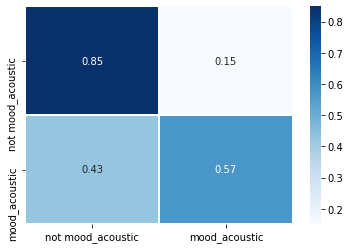

---------------------------------------------
Class: mood_aggressive
Accuracy: 0.8913043478260869
ERR:  0.26118538324420676


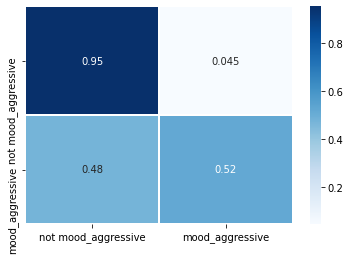

---------------------------------------------
Class: mood_electronic
Accuracy: 0.7491638795986622
ERR:  0.21894930207888644


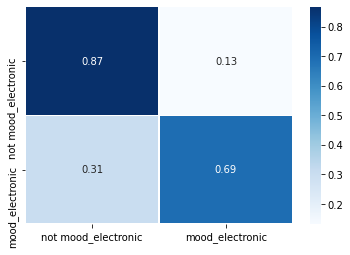

---------------------------------------------
Class: mood_happy
Accuracy: 0.7040133779264214
ERR:  0.36887839767420916


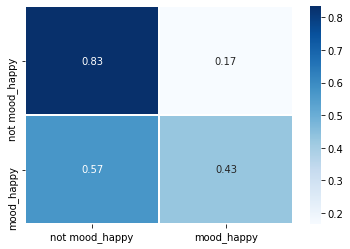

---------------------------------------------
Class: mood_party
Accuracy: 0.14046822742474915
ERR:  0.7479757085020242


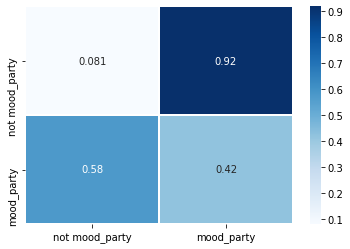

---------------------------------------------
Class: mood_relaxed
Accuracy: 0.23578595317725753
ERR:  0.7354490022172949


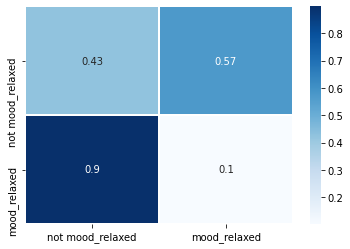

---------------------------------------------
Class: mood_sad
Accuracy: 0.3729096989966555
ERR:  0.6454326923076923


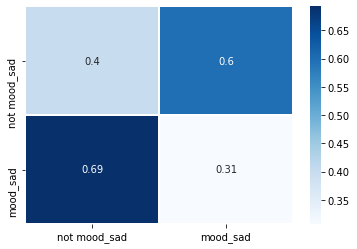

In [29]:
# plot all confusion matrix for CNN mood
for mood_class in mood_gt_classification_dict.keys():
  print('---------------------------------------------')
  print('Class:', mood_class)
  gt_mood_class = list(map(int, mood_gt_classification_dict[mood_class]))
  pred_mood_class = mood_cnn_classification_dict[mood_class]
  matrix_test = confusion_matrix(gt_mood_class, pred_mood_class, normalize='true')
  accuracy_mood_class = accuracy_score(gt_mood_class, pred_mood_class)
  print("Accuracy: {}".format(accuracy_mood_class))
  tn, fp, fn, tp = matrix_test.ravel()
  ERR = (fp + fn)/(tn + tp + fp + fn)
  print("ERR: ", ERR)
  ax = sns.heatmap(matrix_test, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['not ' + mood_class, mood_class], yticklabels= ['not ' + mood_class, mood_class])
  plt.show()

---------------------------------------------
Class: danceability
Accuracy: 0.6672240802675585
ERR:  0.27132280959373467


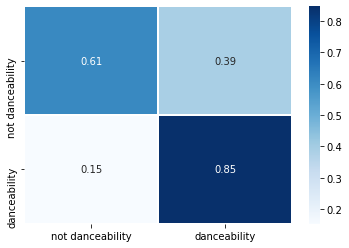

---------------------------------------------
Class: gender
Accuracy: 0.27591973244147155


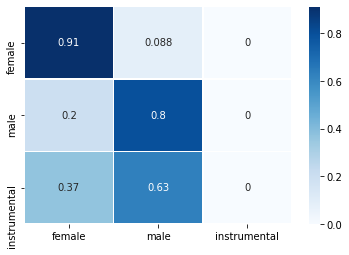

---------------------------------------------
Class: tonal_atonal
Accuracy: 0.5702341137123745
ERR:  0.5885511651469099


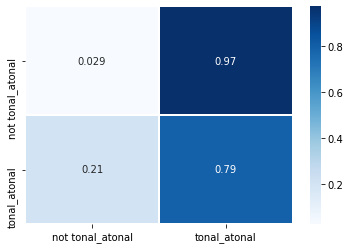

---------------------------------------------
Class: voice_instrumental
Accuracy: 0.1705685618729097
ERR:  0.8602053140096618


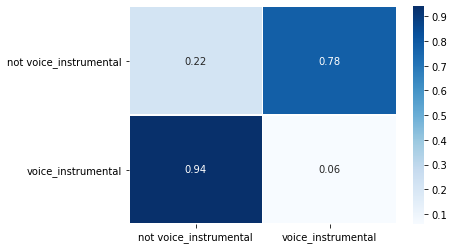

In [30]:
# plot all confusion matrix for CNN miscellanous
for misc_class in misc_gt_classification_dict.keys():
  print('---------------------------------------------')
  print('Class:', misc_class)
  gt_misc_class = list(map(int, misc_gt_classification_dict[misc_class]))
  pred_misc_class = misc_cnn_classification_dict[misc_class]

  if misc_class == 'gender':
    label = ['female', 'male', 'instrumental']
    matrix_test = confusion_matrix(gt_misc_class, pred_misc_class, normalize='true')
    #print(matrix_test)
    accuracy_misc_class = accuracy_score(gt_misc_class, pred_misc_class)
    print("Accuracy: {}".format(accuracy_misc_class))
    ax = sns.heatmap(matrix_test, linewidth=0.5, annot=True, cmap="Blues", xticklabels= label, yticklabels= label)
    plt.show()
  else:
    matrix_test = confusion_matrix(gt_misc_class, pred_misc_class, normalize='true')
    #print(matrix_test)
    accuracy_misc_class = accuracy_score(gt_misc_class, pred_misc_class)
    print("Accuracy: {}".format(accuracy_misc_class))
    tn, fp, fn, tp = matrix_test.ravel()
    ERR = (fp + fn)/(tn + tp + fp + fn)
    print("ERR: ", ERR)
    ax = sns.heatmap(matrix_test, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['not ' + misc_class, misc_class], yticklabels= ['not ' + misc_class, misc_class])
    plt.show()

---------------------------------------------
Class: mood_acoustic
Accuracy: 0.6254180602006689
ERR:  0.31239605081566935


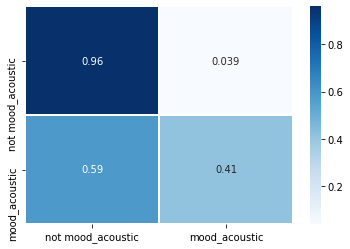

---------------------------------------------
Class: mood_aggressive
Accuracy: 0.862876254180602
ERR:  0.21203208556149733


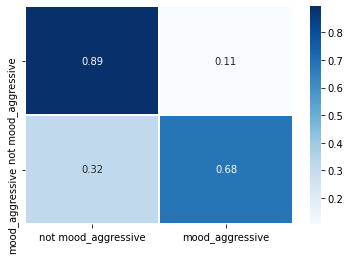

---------------------------------------------
Class: mood_electronic
Accuracy: 0.7591973244147158
ERR:  0.21019132999573098


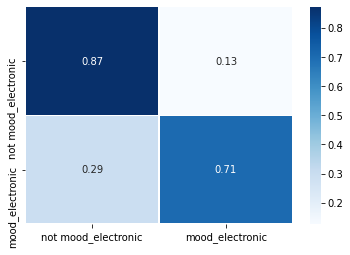

---------------------------------------------
Class: mood_happy
Accuracy: 0.6739130434782609
ERR:  0.39515931924308884


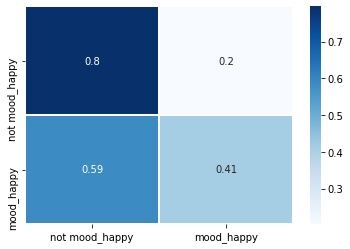

---------------------------------------------
Class: mood_party
Accuracy: 0.13712374581939799
ERR:  0.8790485829959513


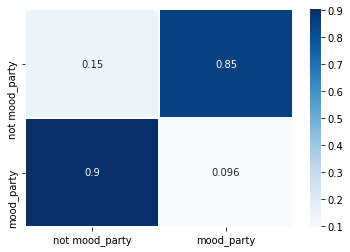

---------------------------------------------
Class: mood_relaxed
Accuracy: 0.17725752508361203
ERR:  0.8108716740576496


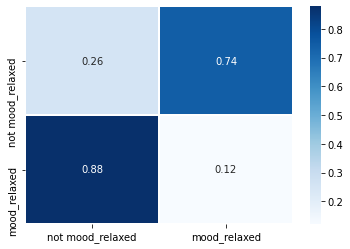

---------------------------------------------
Class: mood_sad
Accuracy: 0.3862876254180602
ERR:  0.615728021978022


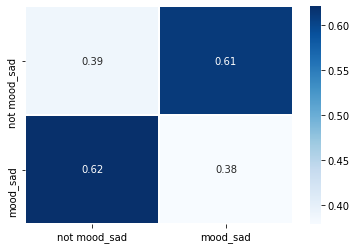

In [31]:
# plot all confusion matrix for VGGish mood
for mood_class in mood_gt_classification_dict.keys():
  print('---------------------------------------------')
  print('Class:', mood_class)
  gt_mood_class = list(map(int, mood_gt_classification_dict[mood_class]))
  pred_mood_class_vgg = mood_vgg_classification_dict[mood_class]
  accuracy_mood_class_vgg = accuracy_score(gt_mood_class, pred_mood_class_vgg)
  print("Accuracy: {}".format(accuracy_mood_class_vgg))
  matrix_test = confusion_matrix(gt_mood_class, pred_mood_class_vgg, normalize='true')
  tn, fp, fn, tp = matrix_test.ravel()
  ERR = (fp + fn)/(tn + tp + fp + fn)
  print("ERR: ", ERR)
  ax = sns.heatmap(matrix_test, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['not ' + mood_class, mood_class], yticklabels= ['not ' + mood_class, mood_class])
  plt.show()

---------------------------------------------
Class: danceability
Accuracy: 0.725752508361204
ERR:  0.23040565345080768


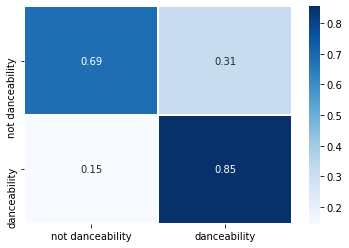

---------------------------------------------
Class: gender
Accuracy: 0.25585284280936454


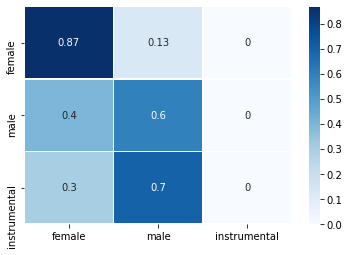

---------------------------------------------
Class: tonal_atonal
Accuracy: 0.3963210702341137
ERR:  0.7165079365079365


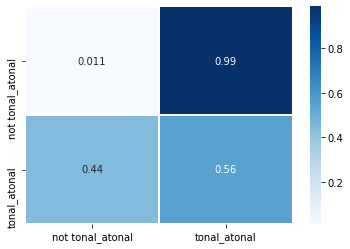

---------------------------------------------
Class: voice_instrumental
Accuracy: 0.13712374581939799
ERR:  0.8783212560386473


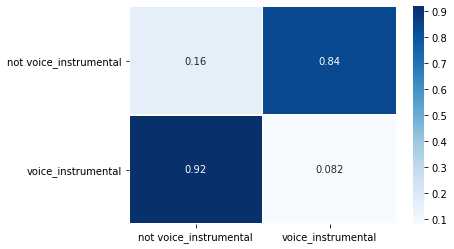

In [32]:
# plot all confusion matrix for VGGish misc
for misc_class in misc_gt_classification_dict.keys():
  print('---------------------------------------------')
  print('Class:', misc_class)
  gt_misc_class = list(map(int, misc_gt_classification_dict[misc_class]))
  pred_misc_class = misc_vgg_classification_dict[misc_class]

  if misc_class == 'gender':
    label = ['female', 'male', 'instrumental']
    matrix_test = confusion_matrix(gt_misc_class, pred_misc_class, normalize='true')
    #print(matrix_test)
    accuracy_misc_class = accuracy_score(gt_misc_class, pred_misc_class)
    print("Accuracy: {}".format(accuracy_misc_class))
    ax = sns.heatmap(matrix_test, linewidth=0.5, annot=True, cmap="Blues", xticklabels= label, yticklabels= label)
    plt.show()
  else:
    matrix_test = confusion_matrix(gt_misc_class, pred_misc_class, normalize='true')
    #print(matrix_test)
    accuracy_misc_class = accuracy_score(gt_misc_class, pred_misc_class)
    print("Accuracy: {}".format(accuracy_misc_class))
    tn, fp, fn, tp = matrix_test.ravel()
    ERR = (fp + fn)/(tn + tp + fp + fn)
    print("ERR: ", ERR)
    ax = sns.heatmap(matrix_test, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['not ' + misc_class, misc_class], yticklabels= ['not ' + misc_class, misc_class])
    plt.show()

More information about the task are available on the report: https://github.com/RonFrancesca/Analysis_Essentia_models-MTG_Jamendo-dataset/